# **TIME SERIES ANIMATION CYCLE NETWORK**
This notebook creates a **GIF animation of the bicycle infrastructure** of a desired study area. This allows the annual development to be predicted from 2008 onwards.

<img src="https://i.imgur.com/HB73o3U.gif" alt="drawing" width="600"/>

# Import Libraries

In [ ]:
!pip install --quiet osmnx contextily ohsome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 40.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [ ]:
import osmnx
from ohsome import OhsomeClient
import geopandas as gpd
import pandas as pd
import json

import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
from dateutil.relativedelta import relativedelta
from datetime import datetime
import numpy as np

# Define study area

Change the current area to desired investigation area

In [ ]:
area ='Wien'

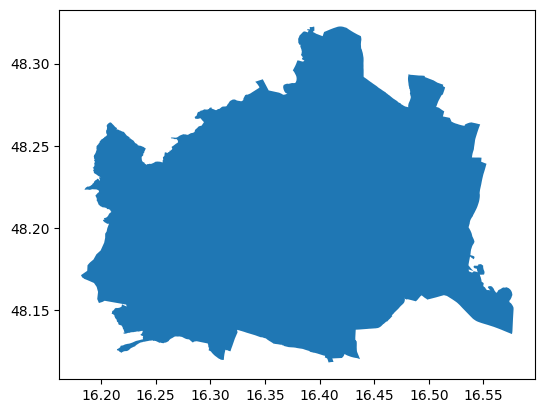

In [ ]:
# @title Nominatim query
gdf_area = osmnx.geocode_to_gdf(area)
gdf_area.plot()
plt.show()
#Get the area as a GEOJSON file
gjson_area = gdf_area.to_json()

# areaID is always osm_id + 3600000000, has to be a relation, gdf_area.osm_id comes from osmnx nominatim query above
areaId = gdf_area.osm_id[0] + 3600000000

# Query


<big>⌛</big>Calling the OSHOME API **can take up to 30 minutes** at very large areas!<big>⌛</big>

In [ ]:
# @title Overpass Turbo Wizard Query Strings
opwizquery_cycle_tracks = "(highway=cycleway or (highway=path or highway= footway) and (bicycle=designated or bicycle=yes or bicycle=permissive) or (cycleway=track or cycleway=opposite_track) or (cycleway:right=track or cycleway:right=opposite_track) or (cycleway:left=track or cycleway:left=opposite_track) or (cycleway:both=track or cycleway:both=opposite_track))"
opwizquery_cycle_lanes = "(cycleway=lane or cycleway=opposite_lane) or (cycleway:right=lane or cycleway:right=opposite_lane) or (cycleway:left=lane or cycleway:left=opposite_lane) or (cycleway:both=lane or cycleway:both=opposite_lane)"
opwizquery_calm_traffic_ways = "((highway=track or highway=service or highway=unclassified or highway=residential) and ((motor_vehicle=private or motor_vehicle=no or motor_vehicle=customers or motor_vehicle=agricultural or motor_vehicle=forestry or motor_vehicle=destination or motor_vehicle=delivery) or (access=private or access=no or access=customers or access=agricultural or access=forestry or access=destination or access=delivery)) and (bicycle=designated or bicycle=yes or bicycle=permissive)) or (highway=track and (bicycle=designated or bicycle=yes or bicycle=permissive) and (motor_vehicle!=* and access!=*)) or(highway=track and (bicycle!=*) and (motor_vehicle=private or motor_vehicle=no or motor_vehicle=customers or motor_vehicle=agricultural or access=forestry or access=destination or access=delivery))"


In [ ]:
# @title Fetch data from OSHOME API
#Set current year for API query; subtract 2 months because OSHOME API has a time delay (otherwise may gives back error)
dt_2_months_delay = datetime.today() - relativedelta(months=2)
year = int(dt_2_months_delay.strftime('%Y'))

client = OhsomeClient()
gdf_list = []

years = np.arange(2008, year+1, 1)
# Fetch with Oshome py library for every year
for year in years:
  for query, class_name in zip((opwizquery_cycle_tracks, opwizquery_cycle_lanes, opwizquery_calm_traffic_ways),
                    ('cycle_tracks', 'cycle_lanes', 'calm_traffic_ways')):
    response = client.elements.geometry.post(bpolys=gjson_area,
					  time=f'{year}-01-01',
					  filter=query,
					  properties='tags')
    response_gdf = response.as_dataframe()
    response_gdf['year'] = year
    response_gdf['infr_class'] = class_name
    gdf_list.append(response_gdf)
  print(f"\rFeatures for year {year} succesfully fetched!", end='')

Features for year 2024 succesfully fetched!

In [ ]:
# @title Stack all GDFs into one
# All GDFs for every year into one GDF
gdf_total = gpd.GeoDataFrame(
    pd.concat(gdf_list, ignore_index=True),crs=gdf_list[0].crs)

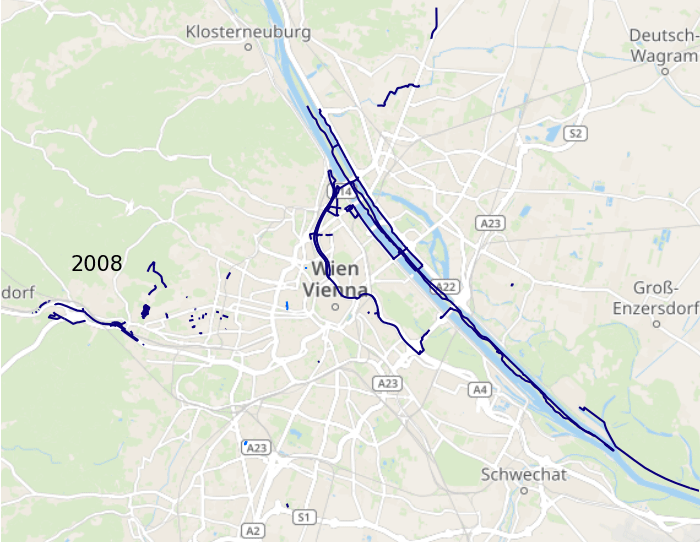

In [ ]:
# @title Make a GIF file of the changes over time
gdf_total = gdf_total.to_crs(epsg=3857)
# Calculate  minimum and maximum longitudes and latitudes
min_longitude, min_latitude, max_longitude, max_latitude = gdf_total.geometry.total_bounds
# Calculate the aspect ratio of the data
data_aspect_ratio = (max_longitude - min_longitude) / (max_latitude - min_latitude)
# Calculate the figure width and height
fig_width = 7
fig_height = fig_width / data_aspect_ratio

# Create a figure with the correct aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
# No margin
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
# No auto plot
plt.ioff()

colors = {
    'cycle_tracks': '#0a007b',
    'cycle_lanes': '#006bff',
    'calm_traffic_ways': '#c63ddb',
}

# Function to draw each frame of the animation
def draw_frame(year):

    #set back plot /clear all features
    ax.clear()
    # loop through every infr_class in the specific year
    for infr_class, color in colors.items():
      g =gdf_total[(gdf_total['year'] == year) & (gdf_total['infr_class'] == infr_class)]
      if g.empty:
        continue
      g.plot(ax=ax, color=color)
      ax.axis('off')  # Turn off the axis (axis values frame)

    # Set the x and y limits of the plot
    ax.set_xlim([min_longitude, max_longitude])
    ax.set_ylim([min_latitude, max_latitude])
    cx.add_basemap(ax, source='https://tile.thunderforest.com/atlas/{z}/{x}/{y}.png?apikey=3ad11fafa2564c1183c66f15224857b5')

    ax.text(0.1, 0.5, str(year), transform=ax.transAxes, fontsize=15)

# Create the animation
ani = animation.FuncAnimation(fig, draw_frame, frames=years, repeat_delay=3000, interval=800,)

# Convert the animation to HTML5 video (for Jupyter notebook) and display it
ani.save('timeseries_cycle_infrastructure.gif')
Image(filename='timeseries_cycle_infrastructure.gif')